In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import os
import sys
sys.path.insert(0,'python')
from PSF_optimization import *
from fastRWpkl import *
from get_wrs import *
from linear_plot import *
from smoothn import *
plot_config()
import pylab as plt
%matplotlib inline
import kernels
from get_brdf import *

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
directory = os.getcwd()+'/'
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doys

[38, 70, 86, 134, 150]

In [4]:
def read_meta(Hfile):
    
    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if 'CLOUD_COVER ' in line:
                cloud_cover =  float(line.split('= ')[1])
    if cloud_cover<20:
        #print 'Less than 20% cloud.'
        b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
        corners = b1.shape
        dic = {}
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif 'ROLL_ANGLE' in line:
                    vza = float(line.split(' = ')[1])
                elif 'SUN_AZIMUTH' in line:
                    saa = float(line.split(' = ')[1])
                elif 'SUN_ELEVATION' in line:
                    sza = float(line.split(' = ')[1])
        with open('Landsat_azm.pkl', 'r') as savefile:
            Landsat_azm = pkl.load(savefile)

        vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
        
        return sza, saa, vza, vaa, dic, corners
    else:
        print 'To much cloud: ', cloud_cover
        return None  
sza, saa, vza, vaa, dic, corners = read_meta('l_data/LC81220342016038LGN00_sr_')
L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)
Lx, Ly = L_inds
Hx, Hy = H_inds

In [5]:
fnames = [i.split('/')[-1].split('_sr')[0] for i in Hfiles]
fnames

['LC81220342016038LGN00',
 'LC81220342016070LGN00',
 'LC81220342016086LGN00',
 'LC81220342016134LGN00',
 'LC81220342016150LGN00']

In [6]:
temp = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_%s'
angs_qc = ['1km_2D:SensorZenith_1', '1km_2D:SensorAzimuth_1', '1km_2D:SolarZenith_1', '1km_2D:SolarAzimuth_1', '500m_2D:QC_500m_1']
bands = ['500m_2D:sur_refl_b%02d_1'%i for i in range(1,8)]
keys = angs_qc + bands
keys

['1km_2D:SensorZenith_1',
 '1km_2D:SensorAzimuth_1',
 '1km_2D:SolarZenith_1',
 '1km_2D:SolarAzimuth_1',
 '500m_2D:QC_500m_1',
 '500m_2D:sur_refl_b01_1',
 '500m_2D:sur_refl_b02_1',
 '500m_2D:sur_refl_b03_1',
 '500m_2D:sur_refl_b04_1',
 '500m_2D:sur_refl_b05_1',
 '500m_2D:sur_refl_b06_1',
 '500m_2D:sur_refl_b07_1']

In [ ]:
def three_days_fitting(doy, h,v, Lx, Ly):
    
    temp = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_%s'
    angs_qc = ['1km_2D:SensorZenith_1', '1km_2D:SensorAzimuth_1', '1km_2D:SolarZenith_1', '1km_2D:SolarAzimuth_1', '500m_2D:QC_500m_1']
    bands = ['500m_2D:sur_refl_b%02d_1'%i for i in range(1,8)]
    keys = angs_qc + bands
    
    files = [glob.glob('m_data/M?D09*.A2016%03d.h27v05.006.*.hdf'%i) for i in range(doy-1, doy+1+1)]
    Ref_3_days = []
    for fname in files:
        data = []
        for fi in fname:
            for key in keys:
                dat = gdal.Open(temp%(fi, key)).ReadAsArray()
                if dat.shape !=(2400,2400):
                    dat = np.repeat(np.repeat(dat,2, axis=1), 2, axis=0)
                data.append(dat[Lx,Ly])
        Ref_3_days.append(data)
    Ref_3_days = np.array(Ref_3_days)
    mod_kk = []
    for angle in Ref_3_days[:,:4,:]:
        vz, va, sz, sa = angle*0.01
        raa = va-sa
        kk = get_kk([vz, sz, raa])
        mod_kk.append(kk)
    
    myd_kk = []
    for angle in Ref_3_days[:,12:16,:]:
        vz, va, sz, sa = angle
        raa = va-sa
        kk = get_kk([vz, sz, raa])
        myd_kk.append(kk)
    kks = mod_kk+myd_kk
    ks = np.ones((6, 3, len(Lx)))
    for i, j in enumerate(kks):
        ks[i,1:, :] = j.Ross,j.Li
        
    paras = []
    for i in range(len(Lx)):
        X = np.matrix(ks[:,:,i])
        y = np.matrix(Ref_3_days[:,[11,-1],i].reshape(6,1))
        b = ((X.T*X)**-1)*(X.T*y)
        paras.append(b)
    
    pas = np.array(paras).squeeze()
    
    m_pre = (ks*pas.T).sum(axis=1)*0.0001
    m_ob = Ref_3_days[:,[11,-1],:].reshape(6, len(Lx))*0.0001
    

In [12]:
doy = 38
files = [glob.glob('m_data/M?D09*.A2016%03d.h27v05.006.*.hdf'%i) for i in range(doy-1, doy+1+1)]
files

[['m_data/MOD09GA.A2016037.h27v05.006.2016039190639.hdf',
  'm_data/MYD09GA.A2016037.h27v05.006.2016229035143.hdf'],
 ['m_data/MOD09GA.A2016038.h27v05.006.2016040113516.hdf',
  'm_data/MYD09GA.A2016038.h27v05.006.2016229062627.hdf'],
 ['m_data/MOD09GA.A2016039.h27v05.006.2016041112033.hdf',
  'm_data/MYD09GA.A2016039.h27v05.006.2016229064320.hdf']]

In [13]:
Ref_3_days = []
for fname in files:
    data = []
    for fi in fname:
        for key in keys:
            #print temp%(fname, key)
            #print temp%fname
            dat = gdal.Open(temp%(fi, key)).ReadAsArray()
            if dat.shape !=(2400,2400):
                dat = np.repeat(np.repeat(dat,2, axis=1), 2, axis=0)
            data.append(dat[Lx,Ly])
    Ref_3_days.append(data)

In [14]:
Ref_3_days = np.array(Ref_3_days)

In [29]:
Ref_3_days[0,:4,:]*0.01

array([[   0.85,    0.85,    0.76, ...,   23.29,   23.29,   23.38],
       [ 100.34,  100.34,  107.14, ...,  -79.28,  -79.28,  -79.27],
       [  57.31,   57.31,   57.31, ...,   54.56,   54.56,   54.56],
       [ 157.61,  157.61,  157.63, ...,  160.1 ,  160.1 ,  160.11]])

In [30]:
mod_kk = []
for angle in Ref_3_days[:,:4,:]:
    vz, va, sz, sa = angle*0.01
    raa = va-sa
    kk = get_kk([vz, sz, raa])
    mod_kk.append(kk)

In [32]:
myd_kk = []
for angle in Ref_3_days[:,12:16,:]:
    vz, va, sz, sa = angle
    raa = va-sa
    kk = get_kk([vz, sz, raa])
    myd_kk.append(kk)

#### Kernel fitting

In [595]:
big = np.matrix(np.zeros((3*100, 6*100)))

In [598]:
for i in range(100):
    big[i*3:i*3+3,i*6:i*6+6] = np.matrix(ks[:,:,i].T)

In [616]:
(Ref_3_days[:,[5,6,7,8,9,10,11, -7,-6,-5,-4,-3,-2,-1], :1000]*0.0001).shape

(3, 14, 1000)

In [613]:
(((big*big.T)**-1)*big).shape

(3000, 6000)

In [593]:
np.all((np.matrix(range(1,15001))*big)!=0)

True

In [574]:
np.matrix([1,2,3])*np.matrix(ks[:,:,0].T)

matrix([[-3.33117204, -4.7401228 , -2.58370501,  0.74627739, -3.67713044,
         -5.71440924]])

In [43]:
i.Ross.shape

(253134,)

In [44]:
kks = mod_kk+myd_kk
ks = np.ones((6, 3, len(Lx)))
for i, j in enumerate(kks):
    ks[i,1:, :] = j.Ross,j.Li

In [537]:
ks.shape

(6, 3, 253134)

In [196]:
kk = get_kk([vz, sz, raa])
k_vol = kk.Ross
k_geo = kk.Li

In [99]:
#b = (X'X)^-1X'y 
paras = []
for i in range(253134):
    X = np.matrix(ks[:,:,i])
    y = np.matrix(Ref_3_days[:,[11,-1],i].reshape(6,1))
    b = ((X.T*X)**-1)*(X.T*y)
    paras.append(b)

In [104]:
pas = np.array(paras).squeeze()

In [123]:
((ks[:,:,0]*pas[0]).sum(axis=-1) - Ref_3_days[:,[11,-1],0].ravel())*0.0001

array([-0.01774044,  0.0057853 ,  0.03612155, -0.01061586, -0.00385661,
       -0.00969394])

In [132]:
(ks*pas.T).sum(axis=1)

array([[ 2248.59562844,  2184.1449489 ,  2206.56262086, ...,
         2123.8626812 ,  2151.71740241,  2247.46520347],
       [ 2154.85296717,  2105.40808312,  2090.03756955, ...,
         2144.23846993,  2127.28157067,  2252.91980635],
       [ 2270.21550734,  2189.12498498,  2249.64450576, ...,
         2129.45833415,  2149.8190697 ,  2247.43855525],
       [ 2408.84135975,  2266.6821124 ,  2368.73741728, ...,
         2515.7965644 ,  2651.60496002,  2638.73378995],
       [ 2466.4339125 ,  2480.02818687,  2330.61577732, ...,
         1878.43167385,  2111.47676234,  2414.49125857],
       [ 2011.06062479,  1947.61168373,  2004.40210922, ...,
         2238.21227649,  2205.10023487,  2217.95138641]])

In [131]:
Ref_3_days[:,[11,-1],:].reshape(6,253134)

array([[2426, 2156, 2349, ..., 1809, 1809, 2093],
       [2097, 2043, 2043, ..., 2058, 2058, 1957],
       [1909, 1909, 1909, ..., 2856, 2856, 3017],
       [2515, 2397, 2493, ..., 2536, 2671, 2627],
       [2505, 2560, 2372, ..., 1797, 2040, 2400],
       [2108, 2108, 2084, ..., 1974, 1963, 1925]])

In [136]:
sza, vza, vaa-saa

(32.36441434, -0.001, 41.081673473058373)

In [145]:
ang = np.zeros((3,)+sz.shape)
ang[0] = sza
ang[1]= vza
ang[2] = vaa-saa

In [433]:
ang[1], ang[0], ang[2]

(array([-0.001, -0.001, -0.001, ..., -0.001, -0.001, -0.001]),
 array([ 32.36441434,  32.36441434,  32.36441434, ...,  32.36441434,
         32.36441434,  32.36441434]),
 array([ 41.08167347,  41.08167347,  41.08167347, ...,  41.08167347,
         41.08167347,  41.08167347]))

In [542]:
Ref_3_days[:,[11,-1],:]

(3, 2, 253134)

In [158]:
kk = get_kk([ang[1], ang[0], ang[2]])
k_vol = kk.Ross
k_geo = kk.Li
Land_k = np.ones((3, k_vol.shape[0]))
Land_k[1:] = k_vol, k_geo

In [211]:
m_pre = (ks*pas.T).sum(axis=1)*0.0001

In [212]:
m_ob = Ref_3_days[:,[11,-1],:].reshape(6, 253134)*0.0001

In [298]:
dif = m_pre-m_ob
mas = np.all((dif>-0.008)&(dif<0.008),axis=0)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [299]:
prected = (Land_k.T*pas).sum(axis=1)*0.0001

In [300]:
H_data = gdal.Open(Hfiles[0].split('_sr_')[0]+'_toa_band7.tif').ReadAsArray()*0.0001

In [301]:
avker = np.ones((40,40))
navker = avker/avker.sum()
s = signal.fftconvolve(H_data, navker, mode='same')

In [391]:
mass = s[Hx, Hy]>0

(0, 0.4)

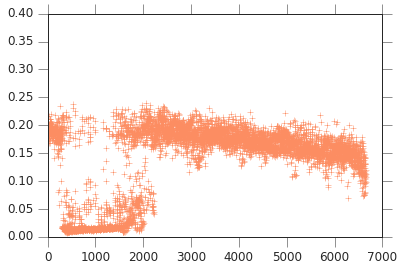

In [392]:
plt.plot(prected[mass&mas],'+')
plt.ylim(0,0.4)

(0, 0.4)

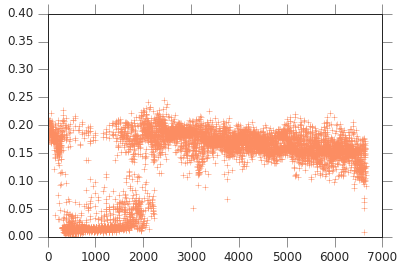

In [393]:
plt.plot(s[Hx, Hy][mass&mas], '+')
plt.ylim(0,0.4)

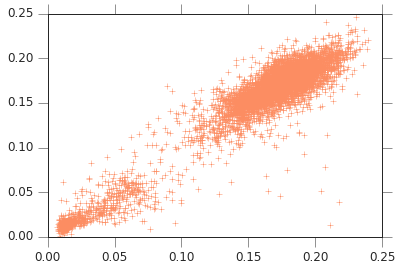

In [394]:
plt.plot(prected[mass&mas],s[Hx, Hy][mass&mas], '+' )

In [395]:
linregress(prected[mass&mas],s[Hx, Hy][mass&mas])

LinregressResult(slope=0.95698053023483642, intercept=0.0026140432469627939, rvalue=0.97252017810752533, pvalue=0.0, stderr=0.002809385539019387)

In [396]:
diff = prected[mass&mas] - H_data[Hx, Hy][mass&mas]

In [397]:
up, down = diff.mean()+ 2*diff.std(), diff.mean()- 2*diff.std()
dif_mask = (diff>down)&(diff<up)

In [398]:
linregress(prected[mass&mas][dif_mask],s[Hx, Hy][mass&mas][dif_mask])

LinregressResult(slope=0.96215860066099501, intercept=0.0020796015818476954, rvalue=0.97755934618422291, pvalue=0.0, stderr=0.0026174547642208038)

(0, 0.3)

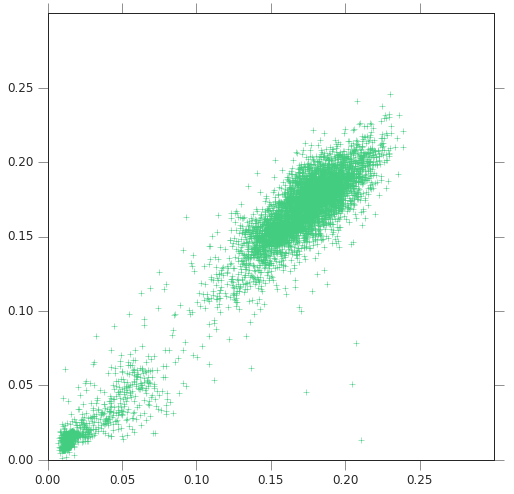

In [399]:
plt.figure(figsize=(8,8))
plt.plot(prected[mass&mas][dif_mask],s[Hx, Hy][mass&mas][dif_mask], '+', color = '#43cd80')
plt.xlim(0,0.3)
plt.ylim(0,0.3)

In [400]:
def cost(p):
    xs,ys = p
    shx, shy = Hx+xs, Hy+ys
    val = (shx>0)&(shx<s.shape[0])&(shy>0)&(shy<s.shape[1])
    r = linregress(prected[mass&mas&val], s[shx[val&mass&mas].astype(int), shy[val&mass&mas].astype(int)])
    return abs(1-r.rvalue)

In [401]:
costs = []
for xs in range(-10,10):
    for ys in range(-10, 10):
        shx, shy = Hx+xs, Hy+ys
        val = (shx>0)&(shx<s.shape[0])&(shy>0)&(shy<s.shape[1])
        r = linregress(prected[mass&mas&val], s[shx[val&mass&mas].astype(int), shy[val&mass&mas].astype(int)])
        costs.append([xs,ys, abs(1-r.rvalue)])

In [402]:
np.where(np.array(costs)==np.array(costs)[:,2].min())

(array([293]), array([2]))

In [403]:
xs, ys = np.array(costs)[293][:2]
shx, shy = Hx+xs, Hy+ys
val = (shx>0)&(shx<s.shape[0])&(shy>0)&(shy<s.shape[1])
mod, land = prected[mass&mas&val], s[shx[val&mass&mas].astype(int), shy[val&mass&mas].astype(int)]
r = linregress(mod, land)
r

LinregressResult(slope=0.95739468101634495, intercept=0.0021643887896596881, rvalue=0.97530987342186271, pvalue=0.0, stderr=0.0026583786624611951)

(0, 0.25)

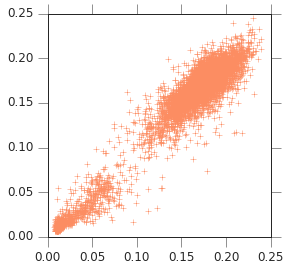

In [404]:
plt.figure(figsize=(4,4))
plt.plot(mod, land, '+')
plt.xlim(0,0.25)
plt.ylim(0,0.25)

In [405]:
dif_f = mod - land
up, down = dif_f.mean()+ 2*dif_f.std(), dif_f.mean()- 2*dif_f.std()
dif_mask = (dif_f>down)&(dif_f<up)

(0, 0.25)

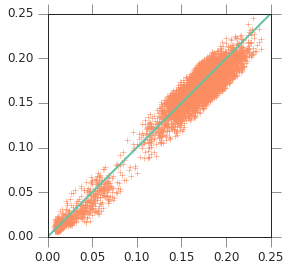

In [428]:
plt.figure(figsize=(4,4))
plt.plot(mod[dif_mask], land[dif_mask], '+')
plt.plot([0,1], [0,1])
plt.xlim(0,0.25)
plt.ylim(0,0.25)

In [423]:
len(mod[dif_mask])

6341

In [375]:
L38 = parallel_rw_pkl(None, 'LC81220342016038LGN00'+'PSF', 'r')

In [376]:
L38_para = [i[0] for i in L38[0]]
L38_cost = [i[1] for i in L38[0]]

In [485]:
BRDF_16_days = L38[1]
mask = BRDF_16_days[8,1,:]<=0

In [486]:
mcd43_pred = BRDF_16_days[8,0,mask&mass]
this_s = s[Hx, Hy][mask&mass]

In [487]:
linregress(mcd43_pred, this_s)

LinregressResult(slope=0.57158332965228253, intercept=0.023626099777081327, rvalue=0.83611726040490864, pvalue=0.0, stderr=0.007442139885947145)

(0, 0.3)

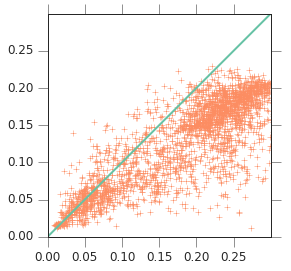

In [427]:
plt.figure(figsize=(4,4))
plt.plot(mcd43_pred, this_s, '+')
plt.plot([0,1], [0,1])
plt.xlim(0,0.3)
plt.ylim(0,0.3)

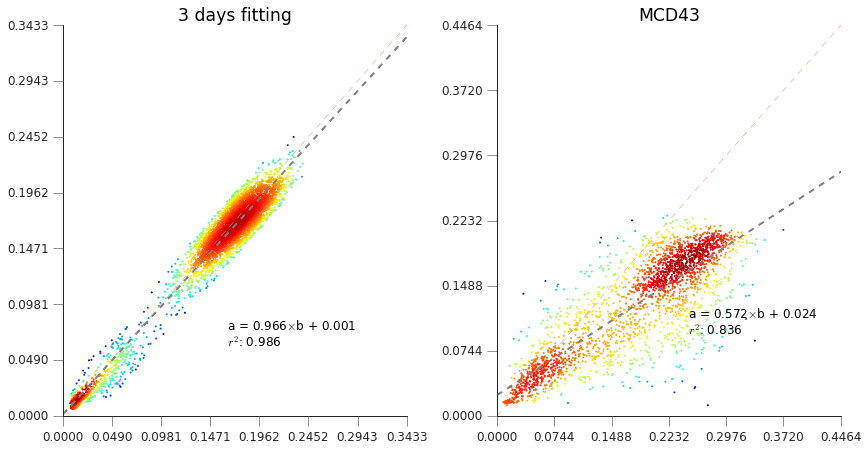

In [432]:
linear_plots([mod[dif_mask], mcd43_pred], [land[dif_mask], this_s], cmap=plt.cm.get_cmap('jet'), titles=('3 days fitting','MCD43'))

#### Using MCD43 BRDF shape

In [445]:
qa = 'HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016038.h27v05.006.2016175000212.hdf":MOD_Grid_BRDF:BRDF_Albedo_Band_Mandatory_Quality_Band7'
mcd43 = 'HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016038.h27v05.006.2016175000212.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band7'

In [449]:
g = gdal.Open(mcd43)
mcd43_paras = g.ReadAsArray()[:, Lx, Ly]
qas = gdal.Open(qa).ReadAsArray()[Lx, Ly]

In [458]:
normlised = 1.*mcd43_paras/mcd43_paras[0]

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [513]:
normlised

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.22826087,  0.3515625 ,  0.22068966, ...,  0.63258786,
         0.21428571,  0.        ],
       [ 0.22101449,  0.22265625,  0.24482759, ...,  0.23642173,
         0.28      ,  0.27937337]])

In [536]:
X = np.matrix(ks[:,:,1])
y = (1.*Ref_3_days[:,[11,-1],:]/f0)[:,:,1].reshape(6,1)
b = ((X.T*X)**-1)*(X.T*y)
b

matrix([[ 1.5309498 ],
        [-0.08378168],
        [ 0.07013895]])

In [521]:
y = np.matrix(Ref_3_days[:,[11,-1],1].reshape(6,1))

In [511]:
f0 = (Ref_3_days[1, -1, :]/ normlised.sum(axis=0))

In [506]:
shap_pred = f0*((Land_k.T).T*normlised).sum(axis=0)*0.0001

In [ ]:
paras = []
for i in range(253134):
    X = np.matrix(ks[:,:,i])
    y = np.matrix(Ref_3_days[:,[11,-1],i].reshape(6,1))
    b = ((X.T*X)**-1)*(X.T*y)
    paras.append(b)

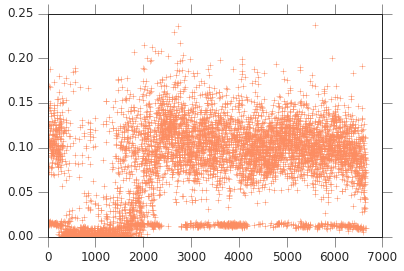

In [507]:
plt.plot(shap_pred[mass*mas], '+')

In [508]:
mcd43_pred = shap_pred[mask&mass]
this_s = s[Hx, Hy][mask&mass]

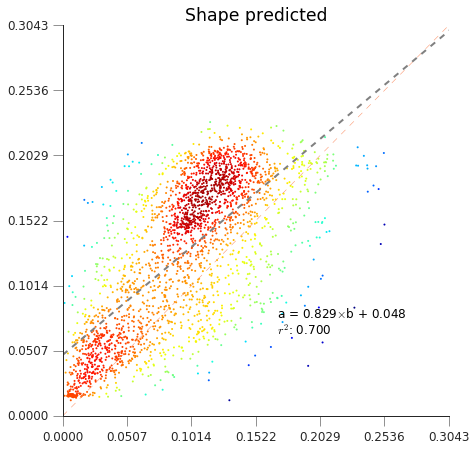

In [509]:
linear_plots([mcd43_pred,], [this_s,], cmap=plt.cm.get_cmap('jet'), titles=('Shape predicted',))